In [65]:
import numpy as np
from numpy import pi
import math

from underactuated import (FindResource, PlanarRigidBodyVisualizer,
                           SliderSystem)

from pydrake.all import (DiagramBuilder, FloatingBaseType,
                         LinearQuadraticRegulator, RigidBodyTree,
                         Saturation, Simulator, WrapToSystem, VectorSystem, SignalLogger)

from pydrake.examples.acrobot import (AcrobotInput, AcrobotPlant, AcrobotState)

import matplotlib.pyplot as plt
from IPython.display import HTML


%matplotlib inline


class LinearController(VectorSystem):
    def __init__(self, k = np.array([-1000,1000,-10,-10]), goal = np.array([pi,0,0,0])):
        VectorSystem.__init__(self,4,1)
        self.k = k
        self.goal = goal
        
          
    def DoCalcVectorOutput(self, context, state, _ , output):
        output[:] = self.k.dot(state - self.goal)
                         
        #output[:] = u
        
def UprightState():
    state = AcrobotState()
    state.set_theta1(math.pi)
    state.set_theta2(0.)
    state.set_theta1dot(0.)
    state.set_theta2dot(0.)
    return state


def BalancingLQR():
    # Design an LQR controller for stabilizing the Acrobot around the upright.
    # Returns a (static) AffineSystem that implements the controller (in
    # the original AcrobotState coordinates).

    acrobot = AcrobotPlant()
    context = acrobot.CreateDefaultContext()

    input = AcrobotInput()
    input.set_tau(0.)
    context.FixInputPort(0, input)

    context.get_mutable_continuous_state_vector()\
        .SetFromVector(UprightState().CopyToVector())

    Q = np.diag((100., 100., 10., 10.))
    R = [.1]

    return LinearQuadraticRegulator(acrobot, context, Q, R)

In [100]:
builder = DiagramBuilder()

acrobot = builder.AddSystem(AcrobotPlant())

saturation = builder.AddSystem(Saturation(min_value=[-20],max_value=[20]))
builder.Connect(saturation.get_output_port(0), acrobot.get_input_port(0))

wrapangles = WrapToSystem(4)
wrapangles.set_interval(0, 0, 2.*math.pi)
wrapangles.set_interval(1, -math.pi, math.pi)
wrapto = builder.AddSystem(wrapangles)
builder.Connect(acrobot.get_output_port(0), wrapto.get_input_port(0))

#k=np.array([[278.44223126, 112.29125985, 119.72457377,  56.82824017]])
k = BalancingLQR().D()
controller = builder.AddSystem(LinearController(k=k))
builder.Connect(wrapto.get_output_port(0), controller.get_input_port(0))
builder.Connect(controller.get_output_port(0), saturation.get_input_port(0))

tree = RigidBodyTree(FindResource("acrobot/acrobot.urdf"),FloatingBaseType.kFixed)

state_logger = builder.AddSystem(SignalLogger(acrobot.get_output_port(0).size()))
act_logger = builder.AddSystem(SignalLogger(controller.get_output_port(0).size()))
builder.Connect(acrobot.get_output_port(0), state_logger.get_input_port(0))
builder.Connect(saturation.get_output_port(0), act_logger.get_input_port(0))


diagram = builder.Build()
simulator = Simulator(diagram)
#simulator.set_target_realtime_rate(1.0)
simulator.set_publish_every_time_step(True)
ing = simulator.get_integrator()
#ing.set_fixed_step_mode(True)

context = simulator.get_mutable_context()

import time

dt = 0.01
t = 0 
init_pert = 0.1*np.random.randn(4,)
print(init_pert)
context.SetContinuousState(UprightState().CopyToVector() + init_pert)
simulator.Initialize()

start_t = time.time()

while(t < 4):
    simulator.AdvanceTo(t)
    t += dt
    
print(time.time() - start_t)


context.SetContinuousState(UprightState().CopyToVector() + init_pert)
simulator.Initialize()

start_t = time.time()
#simulator.AdvanceTo(4)
print(time.time() - start_t)


[-0.12485595  0.05701946  0.01575071  0.06490682]
0.05721759796142578
2.86102294921875e-05


/home/sgillen/miniconda3/envs/drake/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


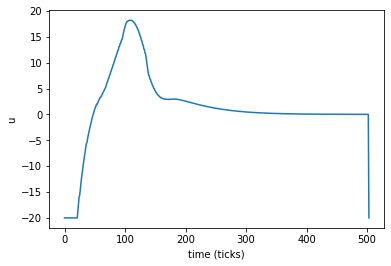

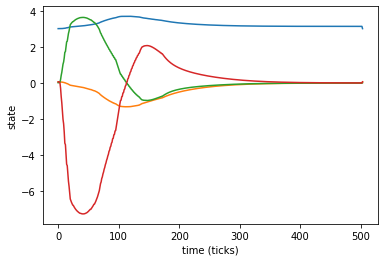

In [101]:
plt.figure()
plt.plot(act_logger.data().transpose(1,0))
plt.xlabel('time (ticks)')
plt.ylabel('u')

plt.figure()
plt.plot(state_logger.data().transpose(1,0))
plt.xlabel('time (ticks)')
plt.ylabel('state')

prbv = PlanarRigidBodyVisualizer(tree, xlim=[-2.5, 2.5], ylim=[-5, 2.5])
ani = prbv.animate(state_logger, repeat=True)
plt.close(prbv.fig)
HTML(ani.to_html5_video())
